In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
import scipy
from scipy import stats
import matplotlib.pyplot as plt
#from sklearn.pipeline import make_pipeline
#from sklearn.compose import make_column_transformer

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
raw_data = pd.read_csv("../data/raw_data.csv")

### Data Observations

##### More than half the dataset is from the NucleaSeq Finkelstein experiments
##### Finkelstein experiments do not contain cell line or chromosome due to being in vitro
##### Finkelstein experiments do not contain target_context
##### Sequences are variable lengths
##### target_sequence ranges in length 20-25 nt
##### grna_target_sequence ranges in length 22-24 nt
##### 75 pairs which do not have a cleavage frequency
##### Length of grna != length of target for some pairs

### Split Training and Testing

In [4]:
df_train, df_test = train_test_split(raw_data, test_size=0.2)

### Preprocessing

In [5]:
class Preprocessing:
    def select(df, params):
        df = df[params].convert_dtypes()
        return df
    
    def drop_na(df, params):
        for col in params:
            df = df[df[col].notna()]
        return df
    
    def remove_dash(df, params):
        for col in df.select_dtypes(exclude=['number']).columns:
            df[col] = [
                seq.replace("-", "")
                for seq in df[col]
            ]
        return df
    
    def pad(df, params):
        for col in df.select_dtypes(exclude=['number']).columns:
            df[col] = df[col].str.pad(width=50, side='right', fillchar='X')
        return df
    
    def encode_nt(nt: str) -> int:
        assert len(nt) == 1
        encoding_dict = {
            'X':0, 
            'A':0.25,
            'T':0.50,
            'G':0.75,
            'C':1.00
        }
        return encoding_dict.get(nt.upper())
    
    def encode_seq(seq: str):
        encoding = [
            Preprocessing.encode_nt(nt)
            for nt in seq
        ]
        return np.array(encoding)
    
    def encode(df, params):
        for col in df.select_dtypes(exclude=['number']).columns:
            df[col] = [
                Preprocessing.encode_seq(seq)
                for seq in df[col]
            ]
        return df

##### Version 1

In [6]:
params = ["grna_target_sequence", "target_sequence", "delivery_mode", "cleavage_freq"]

In [7]:
df_train = Preprocessing.select(df_train, params)
df_train = Preprocessing.drop_na(df_train, params)
df_train = Preprocessing.remove_dash(df_train, params)
df_train = Preprocessing.pad(df_train, params)
df_train = Preprocessing.encode(df_train, params)
df_train

,grna_target_sequence,target_sequence,delivery_mode,cleavage_freq
12288,"[0.75, 0.25, 1.0, 0.75, 1.0, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.5, 0.75, 0.25, 0.75, 0.25, 1.0, 0.75, 1.0, 0.5, 0.75, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.75, 0.25, 1.0, 0.75, 1.0, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 1.0, 0.5, 0.75, 0.25, 0.75, 0.25, 1.0, 0.75, 1.0, 0.5, 0.75, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2,3.360987e-04
11349,"[0.75, 0.25, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.25, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 0.5, 1.0, 1.0, 0.75, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.75, 1.0, 0.5, 0.5, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.25, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 0.25, 0.5, 1.0, 1.0, 0.75, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0,4.037469e-02
12385,"[0.75, 0.25, 1.0, 0.75, 1.0, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.5, 0.75, 0.25, 0.75, 0.25, 1.0, 0.75, 1.0, 0.5, 0.75, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.75, 0.25, 1.0, 0.75, 1.0, 0.25, 0.5, 0.25, 0.25, 1.0, 0.75, 0.25, 1.0, 0.75, 0.25, 0.75, 0.25, 1.0, 0.75, 1.0, 0.5, 0.75, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2,2.646545e-04
20824,"[0.75, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.75, 0.75, 0.25, 0.25, 0.5, 0.75, 1.0, 1.0, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.75, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.75, 0.75, 0.25, 0.25, 0.5, 0.75, 1.0, 1.0, 0.25, 0.5, 0.25, 0.5, 0.25, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2,2.053841e-05
21688,"[0.75, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.75, 0.75, 0.25, 0.25, 0.5, 0.75, 1.0, 1.0, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.75, 0.5, 0.75, 0.75, 0.25, 0.5, 0.25, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75, 0.25, 0.25, 0.5, 0.75, 1.0, 1.0, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2,2.865605e-05
...,...,...,...,...
5006,"[0.75, 0.25, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.25, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 0.5, 1.0, 1.0, 0.75, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.25, 1.0, 1.0, 0.25, 0.5, 1.0, 1.0, 1.0, 0.25, 1.0, 1.0, 1.0, 1.0, 0.25, 0.75, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0,1.850000e-04
23951,"[0.75, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.75, 0.75, 0.25, 0.25, 0.5, 0.75, 1.0, 1.0, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.75, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.75, 0.75, 0.25, 0.25, 0.25, 0.5, 0.75, 1.0, 1.0, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2,5.788549e-20
4781,"[0.75, 0.25, 1.0, 1.0, 1.0, 1.0, 1.0, 0.

### Data Transformation

##### According to reference, should transform cleavage rates to approximate a Gaussian with zero mean and variance 𝜎^2=2 using the nonlinear Box–Cox transformation.

##### Values above and below ±2𝜎 should be capped in order to achieve a fixed value range
##### measured cleavage rates below the lowest reported measurement accuracy (10−5 in our case) should be manually transformed to −2𝜎

In [8]:
# Separate out cleavage rates < 10^-5
low_cleavage = df_train[df_train["cleavage_freq"] < 10**-5]
df_train = df_train[df_train["cleavage_freq"]>= 10**-5]

df_train["transformed_cleavage_freq"], _ = stats.boxcox(df_train["cleavage_freq"])

# Scale ** Surely there's an easier way to do this?
m1 = scipy.mean(df_train["transformed_cleavage_freq"])
s1 = stats.tstd(df_train["transformed_cleavage_freq"])
m2 = 0
s2 = math.sqrt(2)
df_train["scaled_cleavage_freq"] = m2 + (df_train["transformed_cleavage_freq"] - m1) * (s2/s1)

# Manually transform outliers
df_train["scaled_cleavage_freq"] = np.where(df_train["scaled_cleavage_freq"] >2*s2, 2*s2,df_train["scaled_cleavage_freq"])
df_train["scaled_cleavage_freq"] = np.where(df_train["scaled_cleavage_freq"] < -2*s2, -2*s2,df_train["scaled_cleavage_freq"])
low_cleavage["scaled_cleavage_freq"] = -2*s2

# 
df_train = df_train.drop(columns=["transformed_cleavage_freq"])
df_train = pd.concat([df_train, low_cleavage])

/home/megan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/megan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  
/home/megan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/megan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1

(array([4154., 1295., 1923., 2746., 1889., 2031., 2544., 1622., 1152.,
        1089.]),
 array([-2.82842712e+00, -2.26274170e+00, -1.69705627e+00, -1.13137085e+00,
        -5.65685425e-01, -4.44089210e-16,  5.65685425e-01,  1.13137085e+00,
         1.69705627e+00,  2.26274170e+00,  2.82842712e+00]),
 <BarContainer object of 10 artists>)

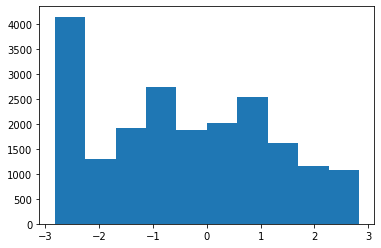

In [9]:
plt.hist(df_train["scaled_cleavage_freq"])

In [10]:
df_train.to_pickle("../data/df_train.pkl")

In [11]:
df_test.to_pickle("../data/df_test.pkl")